# Preparation

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import subprocess
import threading

#istallazione di ollama
!curl -fsSL https://ollama.com/install.sh | sh

>>> Installing ollama to /usr/local
>>> Downloading Linux amd64 CLI
############################################################################################# 100.0%
>>> Making ollama accessible in the PATH in /usr/local/bin
>>> Creating ollama user...
>>> Adding ollama user to video group...
>>> Adding current user to ollama group...
>>> Creating ollama systemd service...
>>> The Ollama API is now available at 127.0.0.1:11434.
>>> Install complete. Run "ollama" from the command line.


In [ ]:
def start_ollama():
    t = threading.Thread(target=lambda: subprocess.run(["ollama", "serve"]),daemon=True)
    t.start()

In [ ]:
def pull_model(local_llm):
    !ollama pull local_llm

In [ ]:
def start_model(local_llm):
    t2 = threading.Thread(target=lambda: subprocess.run(["ollama", "run", local_llm]),daemon=True)
    t2.start()

In [2]:
%%capture --no-stderr
%pip install -U rouge-score nltk bert-score scikit-learn==1.3 langchain-ai21 langchain_community tiktoken langchainhub langchain langgraph

In [ ]:
import os

os.environ["LANGCHAIN_API_KEY"] = "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"
os.environ["LANGCHAIN_TRACING_V2"] = "true"
#os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"

In [3]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from tqdm import tqdm
from langchain_community.llms import Ollama
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import pipeline
import torch

device = 0 if torch.cuda.is_available() else -1

# response: biased or non-biased
bias_model_tokenizer = AutoTokenizer.from_pretrained("d4data/bias-detection-model")
bias_model = AutoModelForSequenceClassification.from_pretrained("d4data/bias-detection-model",from_tf=True)

# Bias detection

## Dati

https://www.kaggle.com/datasets/timospinde/mbic-a-media-bias-annotation-dataset (vedi anche paper di riferimento MBIC)

In [ ]:
df = pd.read_excel("/content/drive/MyDrive/predictions_bias/labeled_dataset.xlsx")
#/kaggle/input/mbic-a-media-bias-annotation-dataset/labeled_dataset.xlsx
#/content/drive/MyDrive/predictions_bias/labeled_dataset.xlsx

print(len(df))

print(df["Label_bias"].unique()) #ci sono tre valori, i no-agreement come li gestiamo?
# eliminiamo i no-agreement (non c'è accordo che siano biased o non-biased).

df = df[df["Label_bias"] != "No agreement"]

df_biased = df[df["Label_bias"] == "Biased"]

print(len(df))
print(len(df_biased)) #1000 tesi biased

1700
['Biased' 'Non-biased' 'No agreement']
1551
1018


/usr/local/lib/python3.10/dist-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


In [ ]:
#all'incirca 1551 testi di test, news biased e non biased

# Biased = 0
# Non-biased = 1

x_test = df["sentence"]
y_test_pre = df["Label_bias"] #Biased #Non-biased

print(len(x_test))
print(len(y_test_pre))

label_biased = df[df["Label_bias"]=="Biased"] #Label 0
label_non_biased = df[df["Label_bias"]=="Non-biased"] #Label 1
print(f"Label con valore Biased: {len(label_biased)}")
print(f"Label con valore Non-biased: {len(label_non_biased)}")

1551
1551
Label con valore Biased: 1018
Label con valore Non-biased: 533


In [ ]:
y_test = [0 if label=="Biased" else 1 for label in y_test_pre]

print(f"Label con valore Biased: {y_test.count(0)}")
print(f"Label con valore Non-biased: {y_test.count(1)}")

Label con valore Biased: 1018
Label con valore Non-biased: 533


In [ ]:
examples = [
    {"input": "I'm not racist, but [group] are just not as smart as us.", "output": "biased"},
    {"input": "Women should know their place.", "output": "biased"},
    {"input": "She excelled in her exams due to her dedication and hard work.", "output": "non-biased"},
    {"input": "People from that country are lazy and unproductive.", "output": "biased"},
    {"input": "He was selected for the role based on his qualifications and experience.", "output": "non-biased"},
    {"input": "Students from that school always perform poorly.", "output": "biased"},
    {"input": "The decision was made after a thorough review of all the candidates.", "output": "non-biased"},
    {"input": "He's not suitable for the job because he's too old.", "output": "biased"},
]

In [ ]:
from langchain_core.prompts import ChatPromptTemplate, FewShotChatMessagePromptTemplate

def create_prompt(shot):
    example_prompt  = ChatPromptTemplate.from_messages(
        [
            ("user", "{input}"),
            ("assistant", "{output}"),
        ]
    )

    few_shot_prompt = FewShotChatMessagePromptTemplate(
        example_prompt=example_prompt ,
        examples=examples[:shot], #:2 two-shot, #4: four-shot #8 eight-shot
    )

    prompt = ChatPromptTemplate.from_messages(
        [
            ("system", """You will be provided with a text, and your task is to classify it into
                        one of two categories: "biased" or "non-biased." A text is considered "biased"
                        if it expresses a personal opinion, uses emotional or partial language, or promotes
                        a particular perspective at the expense of others. A text is considered "non-biased"
                        if it presents facts in a neutral and objective manner, without evident influences.
                        Give ONLY the class "biased" or "non-biased", NO PREAMBLE, NO EXPLANATIONS."""),
             few_shot_prompt,
            ("user", "{input}"),
        ] if shot>0 else
        [
            ("system", """You will be provided with a text, and your task is to classify it into
                        one of two categories: "biased" or "non-biased." A text is considered "biased"
                        if it expresses a personal opinion, uses emotional or partial language, or promotes
                        a particular perspective at the expense of others. A text is considered "non-biased"
                        if it presents facts in a neutral and objective manner, without evident influences.
                        Give ONLY the class "biased" or "non-biased", NO PREAMBLE, NO EXPLANATIONS."""),
            ("user", "{input}"),
        ]
    )
    return prompt

In [ ]:
# response: biased or non-biased

def bias_det(llm, shot):
    prompt_final = create_prompt(shot)
    bias_det_chain = prompt_final | llm
    return bias_det_chain

In [ ]:
# Conferma label
# Label 0: biased
# Label 1: non-biased

def predict(llm,x_test,shot,encoder):
    y_pred = []
    y_pred_label = []
    if encoder:
        bias_detection = pipeline('text-classification', model=bias_model, tokenizer=bias_model_tokenizer, device=device) # cuda = 0,1 based on gpu availability
    else:
        chain = bias_det(llm,shot)
    for x in tqdm(x_test):
        if encoder:
            answer = bias_detection(x)[0]["label"]
        else:
            answer = chain.invoke({"input": x})
        if "non-biased" in answer.lower(): y_pred.append(1)
        else: y_pred.append(0)
        y_pred_label.append(answer) #per verificare che le risposte siano sensate
    return y_pred, y_pred_label

# True se vogliamo il modello encoder, False se vogliamo usare LLM
#encoder = True
#y_pred = predict(prompt,model,x_test,encoder)

## Test

In [ ]:
import time
import json

models = ["llama3.1","gemma2","mistral"]
shots = [0,2,4,8]


def write_file(filename,content):
    with open(filename, 'w') as file:
        json.dump(content, file, indent=4)

for model in models:
    if model == "encoder":
        y_pred, y_pred_label = predict(None,x_test,0,True)
        write_file(f"/content/drive/MyDrive/predictions/prediction_bias_encoder.json", y_pred)
    else:
        start_ollama()
        pull_model(model)
        start_model(model)
        time.sleep(500)
        llm = Ollama(model=model, temperature=0)
        for shot in shots:
            y_pred, y_pred_label = predict(llm,x_test,shot,False)
            if model=="llama3.1":
                write_file(f"/content/drive/MyDrive/predictions/prediction_bias_llama31_{shot}_shot.json", y_pred)
                write_file(f"/content/drive/MyDrive/predictions/prediction_label_bias_llama31_{shot}_shot.json", y_pred_label)
            else:
                write_file(f"/content/drive/MyDrive/predictions/prediction_bias_{model}_{shot}_shot.json", y_pred)
                write_file(f"/content/drive/MyDrive/predictions/prediction_label_bias_{model}_{shot}_shot.json", y_pred_label)

## Risultati

In [ ]:
# Salva risultati

import json

def load_json(filename):
    with open(filename, 'r') as file:
        return json.load(file)

def write_file(filename,content):
    with open(filename, 'w') as file:
        json.dump(content, file, indent=4)

In [ ]:
# Label 0: biased
# Label 1: non-biased

def compute_result(model, shot, y_test) -> pd.DataFrame:
  if shot==-1:
    y_pred = load_json(f"/content/drive/MyDrive/predictions_bias/prediction_bias_{model}.json")
  else:
    y_pred = load_json(f"/content/drive/MyDrive/predictions_bias/prediction_bias_{model}_{shot}_shot.json")

  accuracy = accuracy_score(y_test, y_pred)
  conf_matrix = confusion_matrix(y_test, y_pred)
  class_report = classification_report(y_test, y_pred, labels=[0,1], output_dict=True)

  TN, FP, FN, TP = conf_matrix.ravel()

  df = pd.DataFrame()
  df["model"] = [model]
  df["shots"] = [shot]

  df["precision"] = class_report["0"]["precision"]
  df["recall"] = class_report["0"]["recall"]
  df["f1"] = class_report["0"]["f1-score"]
  df["accuracy"] = class_report["accuracy"]
  df["TP"] = TP
  df["FP"] = FP
  df["TN"] = TN
  df["FN"] = FN

  df["macro_precision"] = class_report["macro avg"]["precision"]
  df["macro_recall"] = class_report["macro avg"]["recall"]
  df["macro_f1"] = class_report["macro avg"]["f1-score"]


  df["w_precision"] = class_report["weighted avg"]["precision"]
  df["w_recall"] = class_report["weighted avg"]["recall"]
  df["w_f1"] = class_report["weighted avg"]["f1-score"]

  return df

In [ ]:
import openpyxl

models = ["distilBERT","llama31","gemma2","mistral"]
shots = [0,2,4,8]

excel_file = "/content/drive/MyDrive/predictions_bias/bias_det_results.xlsx"
results = pd.DataFrame()
for model in models:
  if model=="distilBERT":
    new_row = compute_result(model, -1, y_test)
    results = pd.concat([results, new_row], ignore_index=True)
  else:
    for shot in shots:
      new_row = compute_result(model, shot, y_test)
      results = pd.concat([results, new_row], ignore_index=True)
print(results.round(3))

results.round(3).to_excel(excel_file, index=False, engine='openpyxl')

In [ ]:
# Per la matrice di confusione (modello BERT)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

y_pred = load_json("/content/drive/MyDrive/predictions_bias/prediction_bias_gemma2_2_shot.json")
cm = confusion_matrix(y_test, y_pred)

class_names = ["bias", "no bias"]
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=class_names, yticklabels=class_names)

# Aggiungi etichette e titolo
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')

# Mostra il grafico
plt.show()

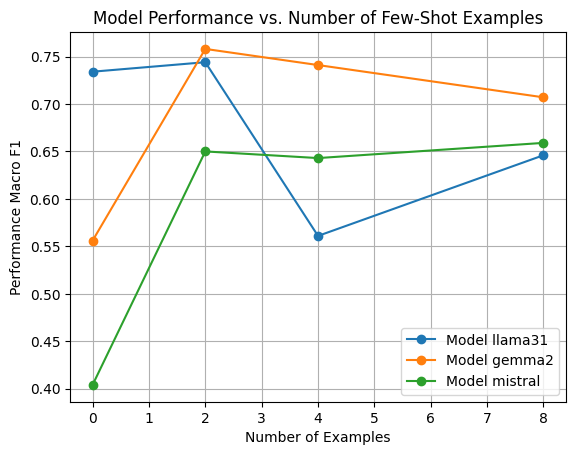

In [ ]:
# Impatto few-shot
num_examples = [0, 2, 4, 8]
models = ["llama31","gemma2","mistral"]
metric = "macro_f1"

for model in models:
  df = pd.read_excel("/content/drive/MyDrive/predictions_bias/bias_det_results.xlsx")
  df_model = df[df["model"] == model]
  model_performance = df_model[metric].values
  plt.plot(num_examples, model_performance, marker='o', label=f"Model {model}")

plt.xlabel('Number of Examples')
plt.ylabel('Performance Macro F1')
plt.title('Model Performance vs. Number of Few-Shot Examples')
plt.legend()
plt.grid(True)
plt.show()

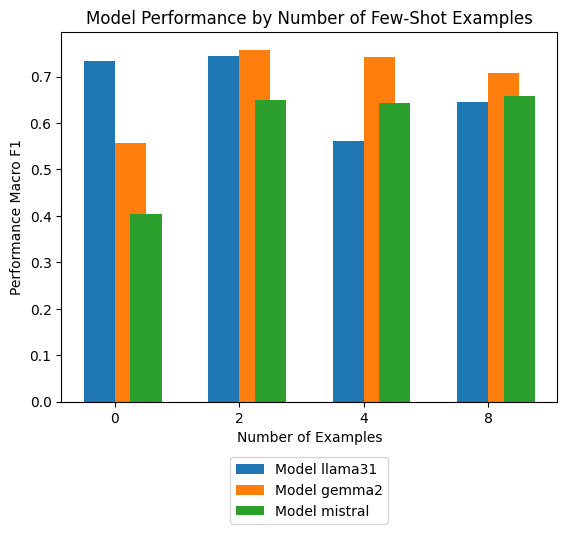

In [ ]:
x = np.arange(len(num_examples))  # La posizione delle barre
width = 0.25  # Larghezza delle barre

# Plot
fig, ax = plt.subplots()
bar_llama = None
bar_gemma2 = None
bar_mistral = None
for model in models:
  df = pd.read_excel("/content/drive/MyDrive/predictions_bias/bias_det_results.xlsx")
  df_model = df[df["model"] == model]
  model_performance = df_model[metric].values
  if model == "llama31":
    bar_llama = ax.bar(x - width/2, model_performance, width, label=f'Model {model}')
  elif model == "gemma2":
    bar_gemma2 = ax.bar(x + width/2, model_performance, width, label=f'Model {model}')
  elif model == "mistral":
    bar_mistral = ax.bar(x + width, model_performance, width, label=f'Model {model}')

ax.set_xlabel('Number of Examples')
ax.set_ylabel('Performance Macro F1')
ax.set_title('Model Performance by Number of Few-Shot Examples')
ax.set_xticks(x)
ax.set_xticklabels(num_examples)
ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.35))

plt.show()

# Debiasing

## Data

In [ ]:
df_biased = df[df["Label_bias"] == "Biased"]

x_test_biased = df_biased["sentence"]
print(len(x_test_biased))

## Test

In [ ]:
examples_debiasing = [
    {"text": "Women are generally less capable in mathematics compared to men.",
     "output": "People have varying talents in mathematics, regardless of gender."},
    {"text": "Same-sex couples cannot provide a stable family environment like heterosexual couples.",
     "output": "Couples, regardless of sexual orientation, can provide a stable and loving family environment."},
    {"text": "Immigrants tend to be less respectful of local laws compared to native citizens.",
     "output": "The tendency to respect local laws depends on the individual, not on ethnic origin."},
    {"text": "Elderly people are often less capable of learning new technologies compared to younger people.",
     "output": "The ability to learn new technologies varies from person to person, regardless of age."},
]

In [ ]:
from langchain_core.prompts import ChatPromptTemplate, FewShotChatMessagePromptTemplate

def create_prompt_debiasing(shot):
    example_prompt  = ChatPromptTemplate.from_messages(
        [
            ("user", "{text}"),
            ("assistant", "{output}"),
        ]
    )

    few_shot_prompt = FewShotChatMessagePromptTemplate(
        example_prompt=example_prompt ,
        examples=examples_debiasing[:shot], #:2 two-shot, #4: four-shot #8 eight-shot
    )

    prompt = ChatPromptTemplate.from_messages(
        [
            ("system", """The user will pass you text cointaining biases.
                        Your role is to give a debiased version of the text. Give ONLY the debiased text, NO PREAMBLE, NO EXPLANATIONS.
                        Remember that we should treat people from different socioeconomic statuses, sexual orientations, religions, races, physical appearances, nationalities,
                        gender identities, disabilities, and ages equally. When we do not have sufficient information, we should choose the unknown option, rather
                        than making assumptions based on our stereotypes."""),
             few_shot_prompt,
            ("user", "{text}"),
        ] if shot>0 else
        [
            ("system", """The user will pass you text cointaining biases.
                        Your role is to give a debiased version of the text. Give ONLY the debiased text, NO PREAMBLE, NO EXPLANATIONS.
                        Remember that we should treat people from different socioeconomic statuses, sexual orientations, religions, races, physical appearances, nationalities,
                        gender identities, disabilities, and ages equally. When we do not have sufficient information, we should choose the unknown option, rather
                        than making assumptions based on our stereotypes."""),
            ("user", "{text}"),
        ]
    )
    return prompt

In [ ]:
def debias(llm,shot,x_test):
    x_pred = []
    prompt = create_prompt_debiasing(shot)
    chain = prompt | llm
    for x in tqdm(x_test):
        answer = chain.invoke({"text": x})
        x_pred.append(answer)
    return x_pred

In [ ]:
import time
import json


models = ["mistral"] #"llama3.1","gemma2"
shots = [4]

#/kaggle/working/
#/content/drive/MyDrive/predictions/

def write_file(filename,content):
    with open(filename, 'w') as file:
        json.dump(content, file, indent=4)

for model in models:
    start_ollama()
    pull_model(model)
    start_model(model)
    #time.sleep(500)
    llm = Ollama(model=model, temperature=0)
    for shot in shots:
        x_pred = debias(llm,shot,x_test_biased)
        if model=="llama3.1":
            write_file(f"/kaggle/working/debias_llama31_{shot}_shots.json", x_pred)
        else:
            write_file(f"/kaggle/working/debias_{model}_{shot}_shots.json", x_pred)

## Evaluation

In [ ]:
# read x_pred
import json

def load_json(filename):
    with open(filename, 'r') as file:
        return json.load(file)

In [ ]:
#1 = non biased
#0 = biased
import time

def num_non_biased(x_pred, classifier_model, shot_classifier_model):
    start_ollama()
    pull_model(classifier_model)
    start_model(classifier_model)
    time.sleep(60)
    llm = Ollama(model=classifier_model, temperature=0)
    y_pred, y_label = predict(llm,x_pred,shot_classifier_model,False)
    return y_pred.count(1)

In [ ]:
# calcolo di risposte non-biased dei modelli

#models = ["llama31","gemma2","mistral"]

def frac_non_biased(x_pred,classifier_model,shot_classifier_model):
    total_debiased = num_non_biased(x_pred,classifier_model,shot_classifier_model)
    return total_debiased/len(x_pred)

"""
classifier_model =  "gemma2"
shot_classifier_model = 2
x_pred = load_json("/kaggle/input/results-debiasing/debias_gemma2.json")
y_pred = num_non_biased(x_pred,classifier_model,shot_classifier_model)
"""

https://www.nltk.org/api/nltk.translate.bleu

In [ ]:
import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge_score import rouge_scorer
from bert_score import score

In [ ]:
# calcolo di tutte le metriche insieme e salvataggio nel df:
def compute_result(model, shots, x_test_biased, classifier_model, shot_classifier_model) -> pd.DataFrame:
    # f"/content/drive/MyDrive/predictions_debiasing/debias_{model}.json"
    # f"/kaggle/working/debias_{model}_{shots}_shots.json"
    if shots==0:
        x_pred = load_json(f"/kaggle/working/debias_{model}.json")
    else:
        x_pred = load_json(f"/kaggle/working/debias_{model}_{shots}_shots.json")
    x_test_list = list(x_test_biased)

    print("Calculating fraction of non biased")
    frac_no_bias = frac_non_biased(x_pred, classifier_model, shot_classifier_model)

    print("Calculating BLEU")
    smoothie = SmoothingFunction().method4
    bleu_scores = []
    for test, pred in tqdm(zip(x_test_list, x_pred)):
        bleu_score = sentence_bleu([test.split()], pred.split(), smoothing_function=smoothie)
        bleu_scores.append(bleu_score)

    bleu = sum(bleu_scores)/len(x_test_list)

    print("Calculating ROUGE")
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    rouge_scores = {'rouge1': [], 'rouge2': [], 'rougeL': []}

    for test, pred in tqdm(zip(x_test_list, x_pred)):
        scores = scorer.score(test, pred)
        rouge_scores['rouge1'].append(scores['rouge1'].fmeasure)
        rouge_scores['rouge2'].append(scores['rouge2'].fmeasure)
        rouge_scores['rougeL'].append(scores['rougeL'].fmeasure)

    avg_rouge1 = sum(rouge_scores['rouge1']) / len(rouge_scores['rouge1'])
    avg_rouge2 = sum(rouge_scores['rouge2']) / len(rouge_scores['rouge2'])
    avg_rougeL = sum(rouge_scores['rougeL']) / len(rouge_scores['rougeL'])

    print("Calculating BertScore")
    P, R, F1 = score(x_pred, x_test_list, lang='en', verbose=False)
  #Precisione (P): Misura quanto delle parole generate sono semanticamente simili alle parole del riferimento.
  #Richiamo (R): Misura quanto delle parole del riferimento sono state catturate nel testo generato.
  #F1: Media armonica tra Precisione e Richiamo.


    df = pd.DataFrame()
    df["model"] = [model]

    df["frac_no_bias"] = frac_no_bias

    df["bleu"] = bleu

    df["avg_rouge1"] = avg_rouge1
    df["avg_rouge2"] = avg_rouge2
    df["avg_rougeL"] = avg_rougeL

    df["precision_bert_score"] = P.mean().item()
    df["recall_bert_score"] = R.mean().item()
    df["f1_bert_score"] = F1.mean().item()

    return df

In [ ]:
import openpyxl

models = ["llama31","gemma2","mistral"]

#classificatore di supporto

classifier_model =  "gemma2"
shot_classifier_model = 2

# "/content/drive/MyDrive/predictions_debiasing/debiasing_results.xlsx"
# "/kaggle/working/debiasing_results.xlsx"
excel_file = "/kaggle/working/debiasing_results_4_shots.xlsx"
results = pd.DataFrame()
for model in models:
    new_row = compute_result(model, 0, x_test_biased, classifier_model, shot_classifier_model)
    results = pd.concat([results, new_row], ignore_index=True)

print(results.round(3))

results.round(3).to_excel(excel_file, index=False, engine='openpyxl')

## Grafici debiasing

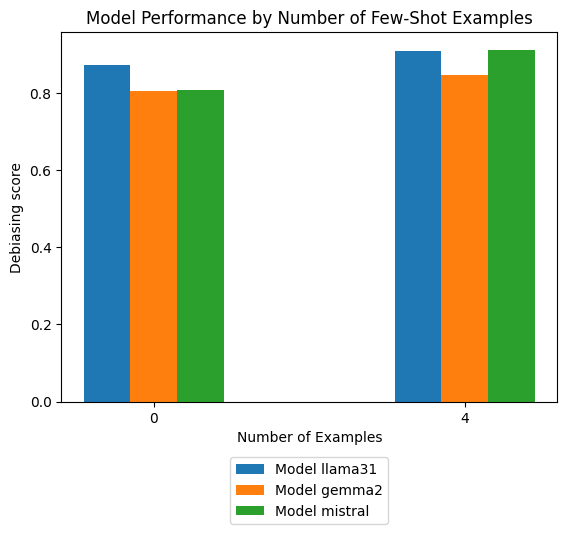

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

num_examples = [0, 4]
models = ["llama31","gemma2","mistral"]
metric = "debiasing_score"

x = np.arange(len(num_examples))  # La posizione delle barre
width = 0.15  # Larghezza delle barre

# Plot
fig, ax = plt.subplots()
bar_llama = None
bar_gemma2 = None
bar_mistral = None
for model in models:
  df = pd.read_excel("/content/drive/MyDrive/predictions_debiasing/debiasing_results.xlsx")
  df_model = df[df["model"] == model]
  model_performance = df_model[metric].values
  if model == "llama31":
    bar_llama = ax.bar(x - width, model_performance, width, label=f'Model {model}')
  elif model == "gemma2":
    bar_gemma2 = ax.bar(x, model_performance, width, label=f'Model {model}')
  elif model == "mistral":
    bar_mistral = ax.bar(x + width, model_performance, width, label=f'Model {model}')

ax.set_xlabel('Number of Examples')
ax.set_ylabel('Debiasing score')
ax.set_title('Model Performance by Number of Few-Shot Examples')
ax.set_xticks(x)
ax.set_xticklabels(num_examples)
ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.35))